<a href="https://colab.research.google.com/github/reiinakano/neural-painters-pytorch/blob/master/notebooks/train_gan_painter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optionally connect to google drive for saving and loading

In [0]:
!nvidia-smi

Fri Dec  6 14:51:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#from google.colab import drive
#drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


# Download dataset

In [0]:
!mkdir -p ~/.kaggle

# Make sure to upload your Kaggle key from somewhere. I saved mine in Drive
#!cp "/drive/My Drive/kaggle.json" ~/.kaggle/

In [0]:
!kaggle datasets download reiinakano/mypaint_brushstrokes

100% 29.9G/29.9G [09:38<00:00, 38.8MB/s]
100% 29.9G/29.9G [09:38<00:00, 55.4MB/s]


In [0]:
!unzip mypaint_brushstrokes.zip

In [0]:
!mv strokes-dataset data

# Install mypaint and other dependencies

In [0]:
# Install mypaint
!apt-get update
!apt install -y build-essential
!apt install -y libjson-c-dev libgirepository1.0-dev libglib2.0-dev
!apt install autotools-dev intltool gettext libtool
!wget https://github.com/mypaint/libmypaint/archive/v2.0.0-alpha.1.tar.gz
!tar -xvf v2.0.0-alpha.1.tar.gz
!mv libmypaint-2.0.0-alpha.1 libmypaint
!cd libmypaint &&  ./autogen.sh
!cd libmypaint && ./configure && make install
!wget https://github.com/mypaint/mypaint-brushes/archive/v2.0.1.tar.gz
!tar -xvf v2.0.1.tar.gz
!mv mypaint-brushes-2.0.1 mypaint-brushes
!cd mypaint-brushes && ./autogen.sh && ./configure && make && make install
!apt-get install -y \
git swig gettext g++ gir1.2-gtk-3.0 libgtk-3-dev \
libpng-dev liblcms2-dev libjson-c-dev python-gi-dev
!apt-get install -y \
python3-setuptools python3-dev python3-numpy python3-gi-cairo

!wget https://github.com/mypaint/mypaint/archive/v2.0.0-alpha.10.tar.gz
!tar -xvf v2.0.0-alpha.10.tar.gz
!mv mypaint-2.0.0-alpha.10 mypaint

!cd mypaint && python setup.py build
!cd mypaint && python setup.py managed_install --prefix=/content/local/
!ldconfig

In [1]:
!pip install kornia

In [2]:
#!rm -r neural-painters-pytorch
#!rm -r neural_painters
!git clone https://github.com/reiinakano/neural-painters-pytorch.git
!cp -r neural-painters-pytorch/neural_painters neural_painters

rm: cannot remove 'neural-painters-pytorch': No such file or directory
rm: cannot remove 'neural_painters': No such file or directory
Cloning into 'neural-painters-pytorch'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 294 (delta 182), reused 200 (delta 103), pack-reused 0
Receiving objects: 100% (294/294), 10.63 MiB | 6.64 MiB/s, done.
Resolving deltas: 100% (182/182), done.


# imports

In [9]:
%tensorflow_version 1.x
%load_ext tensorboard
import sys
sys.path.append('/content/local/lib/mypaint')  # MyPaint is a local installation

import torch
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import moviepy.editor as mpy

from neural_painters.vae_painter import VAENeuralPainter, train_vae_neural_painter
from neural_painters.gan_painter import GANNeuralPainter, train_gan_neural_painter
from neural_painters.data import FullActionStrokeDataLoader
from neural_painters.viz import validate_neural_painter, neural_painter_stroke_animation
from neural_painters.mypaint_env import ColorEnv, PaintMode

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
SCREEN_SIZE = 64
Z_SIZE = 64
KL_TOLERANCE = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# all 0 to 1
ACTIONS_TO_IDX = {
    'pressure': 0,
    'size': 1,
    'control_x': 2,
    'control_y': 3,
    'end_x': 4,
    'end_y': 5,
    'color_r': 6,
    'color_g': 7,
    'color_b': 8,
    'start_x': 9,
    'start_y': 10,
    'entry_pressure': 11,
}

In [11]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

loader = FullActionStrokeDataLoader('data', 64, False)
"""
for batch in loader:
  print(batch['stroke'].shape, batch['action'].shape)
  print(batch['stroke'].mean(), batch['action'].mean())
  imshow(utils.make_grid(batch['stroke']))
  break
"""

"\nfor batch in loader:\n  print(batch['stroke'].shape, batch['action'].shape)\n  print(batch['stroke'].mean(), batch['action'].mean())\n  imshow(utils.make_grid(batch['stroke']))\n  break\n"

# Train

In [0]:
# Optional: Load checkpoints from Drive
#!cp -r /drive/My\ Drive/neural-painters-pytorch/gan_logdir logdir
#!cp -r /drive/My\ Drive/neural-painters-pytorch/gan_train_checkpoints gan_train_checkpoints

In [0]:
%tensorboard --logdir logdir

In [0]:
train_gan_neural_painter(len(ACTIONS_TO_IDX), dim_size=16, noise_dim=16, 
                         batch_size=64, use_reconstruction_loss=True, device=device, 
                         data_dir='data')

Loaded from gan_train_checkpoints/gan_neural_painter_latest.tar. Batch 775000
Loading data/episodes_6.npz
train batch 776000
Loading data/episodes_9.npz
train batch 778000
Loading data/episodes_66.npz
Loading data/episodes_20.npz
train batch 780000
Loading data/episodes_24.npz
train batch 782000
Loading data/episodes_41.npz
train batch 784000
Loading data/episodes_55.npz
Loading data/episodes_4.npz
train batch 786000
Loading data/episodes_22.npz
train batch 788000
Loading data/episodes_62.npz
train batch 790000
Loading data/episodes_10.npz
train batch 792000
Loading data/episodes_72.npz
Loading data/episodes_54.npz
train batch 794000
Loading data/episodes_12.npz
train batch 796000
Loading data/episodes_13.npz
train batch 798000
Loading data/episodes_30.npz
train batch 800000
saved gan_neural_painter_800000.tar
Loading data/episodes_60.npz
Loading data/episodes_27.npz
train batch 802000
Loading data/episodes_1.npz
train batch 804000
Loading data/episodes_25.npz
train batch 806000
Loadin

KeyboardInterrupt: ignored

In [0]:
# Optionally save log directory to Drive
#!mkdir /drive/My\ Drive/neural-painters-pytorch/gan_logdir
#!cp logdir/* /drive/My\ Drive/neural-painters-pytorch/gan_logdir/


In [0]:
# Optionally save checkpoint to Drive
#!mkdir /drive/My\ Drive/neural-painters-pytorch/gan_train_checkpoints
#!cp gan_train_checkpoints/* /drive/My\ Drive/neural-painters-pytorch/gan_train_checkpoints/


# Test trained model

Loading data/episodes_48.npz
Loaded from gan_train_checkpoints/gan_neural_painter_500000.tar. Batch 500000


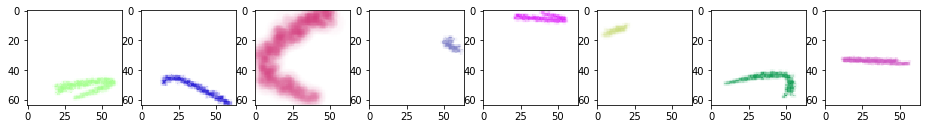

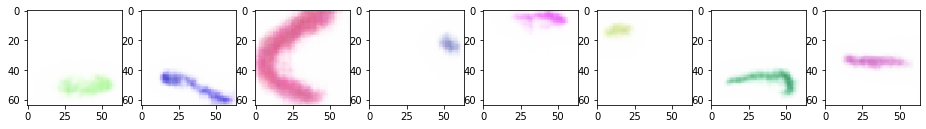

Loaded from gan_train_checkpoints/gan_neural_painter_600000.tar. Batch 600000


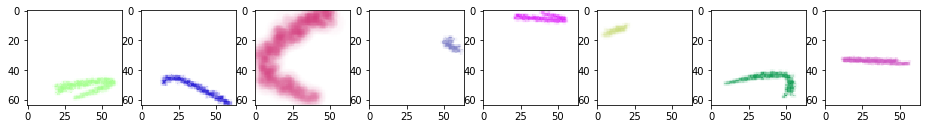

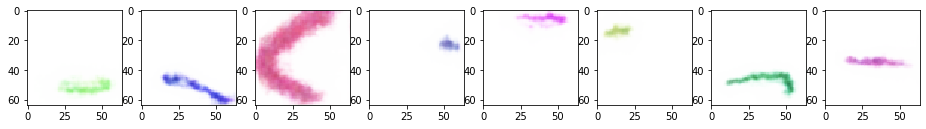

Loaded from gan_train_checkpoints/gan_neural_painter_latest.tar. Batch 1400000


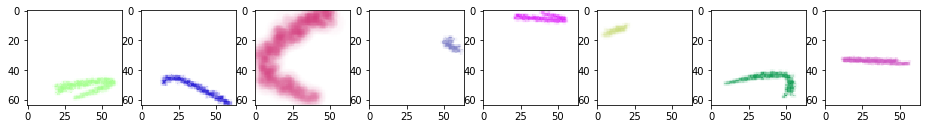

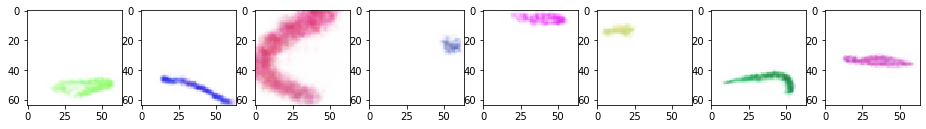

In [12]:
gan_np = GANNeuralPainter(len(ACTIONS_TO_IDX), noise_dim=16, num_deterministic=16).eval()
checkpoints_to_test = ['gan_train_checkpoints/gan_neural_painter_500000.tar',
                       'gan_train_checkpoints/gan_neural_painter_600000.tar',
                       'gan_train_checkpoints/gan_neural_painter_latest.tar']

for idx, batch in enumerate(loader):
  strokes = batch['stroke'].float()[:8]
  actions = batch['action'].float()[:8]
  validate_neural_painter(strokes, actions, gan_np, checkpoints_to_test)
  break

In [13]:
neural_painter_stroke_animation(
    lambda: GANNeuralPainter(len(ACTIONS_TO_IDX), noise_dim=16, num_deterministic=16).eval(), 
    len(ACTIONS_TO_IDX),
    checkpoints_to_test, 'tmp.mp4', real_env=ColorEnv(paint_mode=PaintMode.STROKES_ONLY))
display(mpy.ipython_display('tmp.mp4', height=400))

Loaded from gan_train_checkpoints/gan_neural_painter_500000.tar. Batch 500000
Loaded from gan_train_checkpoints/gan_neural_painter_600000.tar. Batch 600000
Loaded from gan_train_checkpoints/gan_neural_painter_latest.tar. Batch 1400000
[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 300/301 [00:12<00:00, 24.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 



written to tmp.mp4


In [14]:
neural_painter_stroke_animation(
    lambda: GANNeuralPainter(len(ACTIONS_TO_IDX), noise_dim=16, num_deterministic=0).eval(), 
    len(ACTIONS_TO_IDX),
    checkpoints_to_test, 'tmp.mp4', real_env=ColorEnv(paint_mode=PaintMode.STROKES_ONLY))
display(mpy.ipython_display('tmp.mp4', height=400))

Loaded from gan_train_checkpoints/gan_neural_painter_500000.tar. Batch 500000
Loaded from gan_train_checkpoints/gan_neural_painter_600000.tar. Batch 600000
Loaded from gan_train_checkpoints/gan_neural_painter_latest.tar. Batch 1400000
[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 300/301 [00:12<00:00, 25.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 



written to tmp.mp4
